In [5]:
import snowflake.connector

from dotenv import load_dotenv
load_dotenv()
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [6]:
USER = 'chicago'
DATABASE = 'chicago'
SCHEMA = 'dev'
WAREHOUSE = 'compute_wh'
ROLE = 'transform'

ACCOUNT = os.getenv('SNOWFLAKE_ACC_ID')
PASSWORD = os.getenv('SNOWFLAKE_USER_PW')

In [7]:
# Authenticate to Snowflake

conn = snowflake.connector.connect(
    user=USER,
    password=PASSWORD,
    account=ACCOUNT,
    warehouse=WAREHOUSE,
    database=DATABASE,
    schema=SCHEMA,
    role=ROLE
    )

# Create a cursor object.
cur = conn.cursor()

In [8]:
sql_mart_core_metrics = "SELECT * FROM CHICAGO.DEV.MART_CORE_METRICS ORDER BY DATE ASC"
sql_mart_detailed_metrics = "SELECT * FROM CHICAGO.DEV.MART_DETAILED_METRICS ORDER BY DATE DESC LIMIT 3000000"
#sql_mart_fleet_metrics = "SELECT * FROM CHICAGO.DEV.MART_FLEET_METRICS ORDER BY DATE"

# Fetch results and put into dataframe
cur.execute(sql_mart_core_metrics)
df_core = cur.fetch_pandas_all()

cur.execute(sql_mart_detailed_metrics)
df_det = cur.fetch_pandas_all()

#cur.execute(sql_mart_fleet_metrics)
#df_fleet = cur.fetch_pandas_all()

# Close the connection
conn.close()

In [9]:
print(f"{ len(df_core) } rows in Core Metrics df")
print(f"{ len(df_det) } rows in Detailed Metrics df")
#print(f"{ len(df_fleet) } rows in Fleet Metrics df")

2967 rows in Core Metrics df
3000000 rows in Detailed Metrics df


In [10]:
df_det.sort_values('DATE', inplace=True)

### Create reuseable dataframes filtered by date

*Use this to set "today" to the current date*

In [11]:
#today = dt.datetime.now().date()

*Use this to specify the value "today"*

In [12]:
today = dt.date(2023, 2, 28)

In [13]:
print(f"All reports and charts will be created as if today is {str(today)}")

All reports and charts will be created as if today is 2023-02-28


In [31]:
# Filter the dataframes into different date ranges
seven_days_ago = today - dt.timedelta(days=6)
ninety_days_ago = today - dt.timedelta(days=89)
six_months_ago = today - dt.timedelta(days=182)

last_7_days_df = df_core[(df_core['DATE'] >= seven_days_ago) & (df_core['DATE'] <= today)]
last_90_days_df = df_core[(df_core['DATE'] >= ninety_days_ago) & (df_core['DATE'] <= today)]
last_6_months_df = df_core[(df_core['DATE'] >= six_months_ago) & (df_core['DATE'] <= today)]
all_time_df = df_core[df_core['DATE'] <= today]

last_7_days_df_det = df_det[(df_det['DATE'] >= seven_days_ago) & (df_det['DATE'] <= today)]
last_90_days_df_det = df_det[(df_det['DATE'] >= ninety_days_ago) & (df_det['DATE'] <= today)]
last_6_months_df_det = df_det[(df_det['DATE'] >= six_months_ago) & (df_det['DATE'] <= today)]

In [15]:
df_core.head(1)

,YEAR,MONTH,MONTH_NUM,DAY,DATE,PAYMENT_TYPE,TRIP_COUNT,TOTAL_TRIP_DISTANCE_KM,TRIP_DURATION_MINS,FARES_AMOUNT,TIPS_AMOUNT,TOTAL_REVENUE_EXC_TIP,WEATHER_DAILY_TEMP_HIGH,WEATHER_DAILY_TEMP_LOW
0,2022,Jan,1,Saturday,2022-01-01,Credit Card,2330,25589.76,37742.21,53678.21,12814.7,66044.61,5.0,-1.3


In [16]:
df_det.head(1)

,YEAR,MONTH,MONTH_NUM,DAY,DATE,PAYMENT_TYPE,TAXI_ID,PICKUP_COMMUNITY_AREA,DROPOFF_COMMUNITY_AREA,IS_SHORT_TRIP,HAS_TIP,TRIP_COUNT,TOTAL_TRIP_DISTANCE_KM,TRIP_DURATION_MINS,FARES_AMOUNT,TIPS_AMOUNT,TOTAL_REVENUE_EXC_TIP,COMPANY,WEATHER_DAILY_TEMP_HIGH,WEATHER_DAILY_TEMP_LOW
2999999,2022,Sep,9,Wednesday,2022-09-21,Mobile,be7e1462a37397809dadade8e174ef3ccbc3073294df4a...,32,8,1,1,2,4.544,15.8,18.9,3.24,18.9,Blue Ribbon Taxi Association,30.2,18.6


### Trip Volumes

Context:
We want some high-level baseline metrics to get an initial sense of the taxi market in Chicago.

Source table:

- Last 30 day trip volume compared to same time last year
- Visualise total daily trip volumes past few months (line graph)
- Average daily trip duration
- Average trip distance


Potential issues:
doesn't look at longer term trends which might be very useful when considering GTM plan, such as decline in taxi trips over time

Further analysis:
load more historical data going back 10 years and look at the year-on-year trends of the taxi market (suspect it is in major decline due to rise of ride share services). Taxi data alone doesn't give us the total addressable market or size of the competition, but is still helping in forming some view of it.

# Daily Trip Volume - Since 1st Jan 2022

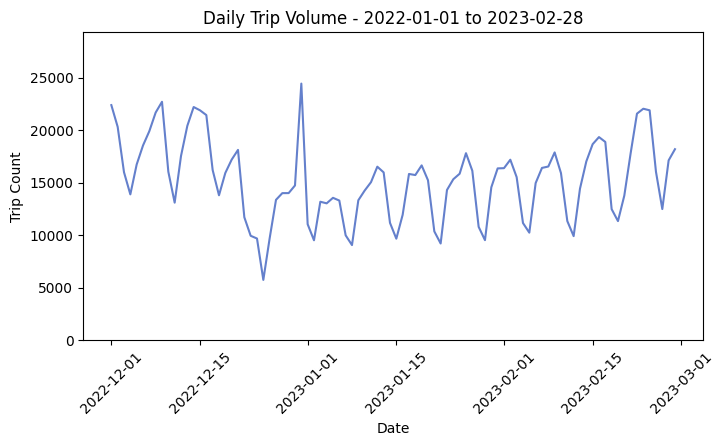

In [107]:
data_source1 = last_90_days_df.groupby('DATE', as_index=False)['TRIP_COUNT'].sum()

plt.figure(figsize=(8, 4))
sns.lineplot(x='DATE', y='TRIP_COUNT', data=data_source1, color='#6480CC')
plt.title(f"Daily Trip Volume - 2022-01-01 to {today}")
plt.xlabel('Date')
plt.ylabel('Trip Count')
plt.ylim(0, max(data_source1['TRIP_COUNT']) * 1.2)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

# Daily Trip Volume - Since 1st Jan 2022

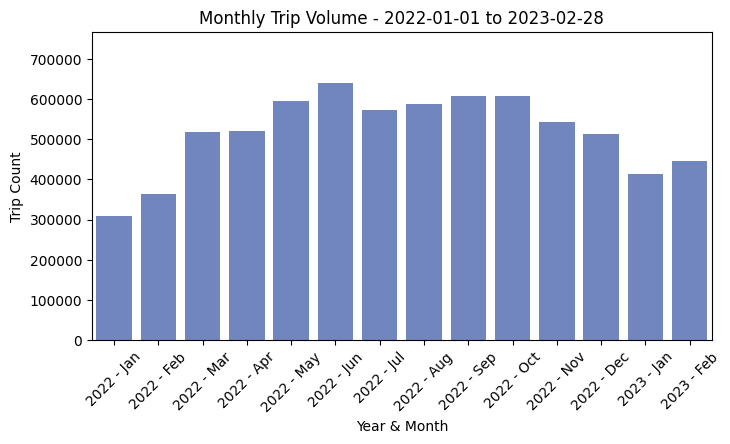

In [37]:
data_source1_2 = all_time_df.groupby(['YEAR', 'MONTH_NUM', 'MONTH'], as_index=False)['TRIP_COUNT'].sum()
data_source1_2['Y_Month'] = data_source1_2['YEAR'] + ' - ' + data_source1_2['MONTH']

plt.figure(figsize=(8, 4))
sns.barplot(x='Y_Month', y='TRIP_COUNT', data=data_source1_2, color='#6480CC')
plt.title(f"Monthly Trip Volume - 2022-01-01 to {today}")
plt.xlabel('Year & Month')
plt.ylabel('Trip Count')
plt.ylim(0, max(data_source1_2['TRIP_COUNT']) * 1.2)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

# Average Daily Trip Duration - Last 90 Days

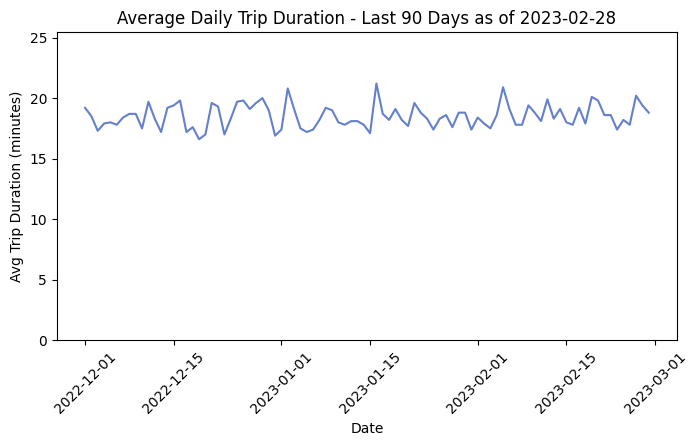

In [148]:
data_source3 = last_90_days_df.groupby('DATE', as_index=False).agg({'TRIP_DURATION_MINS': 'sum', 'TRIP_COUNT': 'sum'})
data_source3['avg_trip_duration'] = (data_source3['TRIP_DURATION_MINS'] / data_source3['TRIP_COUNT']).round(1)

# TO DO: Make x-labels clearer, show weeks or months

plt.figure(figsize=(8, 4))
sns.lineplot(x='DATE', y='avg_trip_duration', data=data_source3, color='#6480CC')
plt.title(f"Average Daily Trip Duration - Last 90 Days as of {today}")
plt.xlabel('Date')
plt.ylabel('Avg Trip Duration (minutes)')
plt.ylim(0, max(data_source3['avg_trip_duration']) * 1.2)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

# Average Daily Trip Distance - Last 90 Days

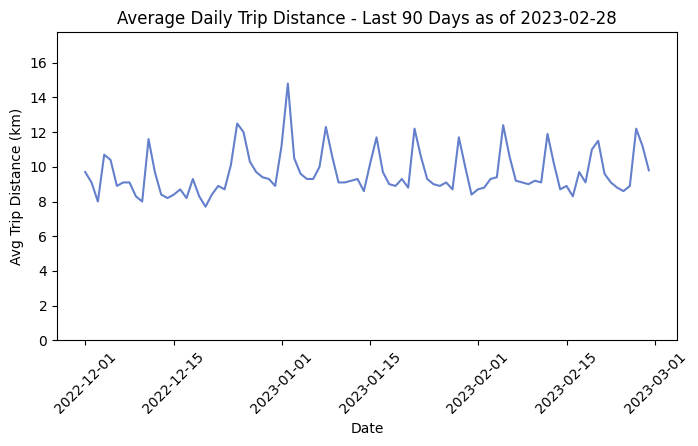

In [149]:
data_source4 = last_90_days_df.groupby('DATE', as_index=False).agg({'TOTAL_TRIP_DISTANCE_KM': 'sum', 'TRIP_COUNT': 'sum'})
data_source4['avg_trip_distance'] = (data_source4['TOTAL_TRIP_DISTANCE_KM'] / data_source4['TRIP_COUNT']).round(1)

# TO DO: Make x-labels clearer, show weeks or months

plt.figure(figsize=(8, 4))
sns.lineplot(x='DATE', y='avg_trip_distance', data=data_source4, color='#6480CC')
plt.title(f"Average Daily Trip Distance - Last 90 Days as of {today}")
plt.xlabel('Date')
plt.ylabel('Avg Trip Distance (km)')
plt.ylim(0, max(data_source4['avg_trip_distance']) * 1.2)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

# Share of Market (from trip count) by Company - Last 6 Months

In [124]:
data_source5 = last_6_months_df_det.groupby(by=['COMPANY'], as_index=False).agg({'TRIP_COUNT': 'sum', 'TOTAL_REVENUE_EXC_TIP': 'sum', 'TOTAL_TRIP_DISTANCE_KM': 'sum'}).sort_values('TRIP_COUNT', ascending=False)
data_source5['TRIP_COUNT'] = data_source5['TRIP_COUNT'].round(0)
data_source5['SHARE_OF_TRIPS_PERC'] = ((data_source5['TRIP_COUNT'] / data_source5['TRIP_COUNT'].sum())*100).round(1)
data_source5['AVG_REVENUE_PER_TRIP'] = (data_source5['TOTAL_REVENUE_EXC_TIP'] / data_source5['TRIP_COUNT']).round(2)
data_source5['AVG_TRIP_DISTANCE_KM'] = (data_source5['TOTAL_TRIP_DISTANCE_KM'] / data_source5['TRIP_COUNT']).round(1)

# TO DO: Rounding not working, format percentage

In [125]:
data_source5['CUMULATIVE_SHARE_OF_TRIPS_PERC'] = data_source5['SHARE_OF_TRIPS_PERC'].cumsum()
data_source5_2 = data_source5[['COMPANY','TRIP_COUNT','SHARE_OF_TRIPS_PERC','CUMULATIVE_SHARE_OF_TRIPS_PERC','AVG_REVENUE_PER_TRIP','AVG_TRIP_DISTANCE_KM']].head(10)
data_source5_2

,COMPANY,TRIP_COUNT,SHARE_OF_TRIPS_PERC,CUMULATIVE_SHARE_OF_TRIPS_PERC,AVG_REVENUE_PER_TRIP,AVG_TRIP_DISTANCE_KM
20,Flash Cab,677914.0,20.3,20.3,23.50,10.7
33,Taxi Affiliation Services,556203.0,16.6,36.9,23.35,6.7
9,5 Star Taxi,426506.0,12.7,49.6,23.22,10.6
32,Sun Taxi,307060.0,9.2,58.8,23.41,10.7
35,"Taxicab Insurance Agency, LLC",300750.0,9.0,67.8,23.96,10.5
19,City Service,275168.0,8.2,76.0,23.30,11.0
14,Chicago Independents,168917.0,5.0,81.0,23.82,10.7
21,Globe Taxi,107086.0,3.2,84.2,23.24,10.9
25,Medallion Leasin,103325.0,3.1,87.3,23.28,10.9
12,Blue Ribbon Taxi Association,83868.0,2.5,89.8,21.16,9.6


# Trip Volume by Payment Type - Last 6 Months

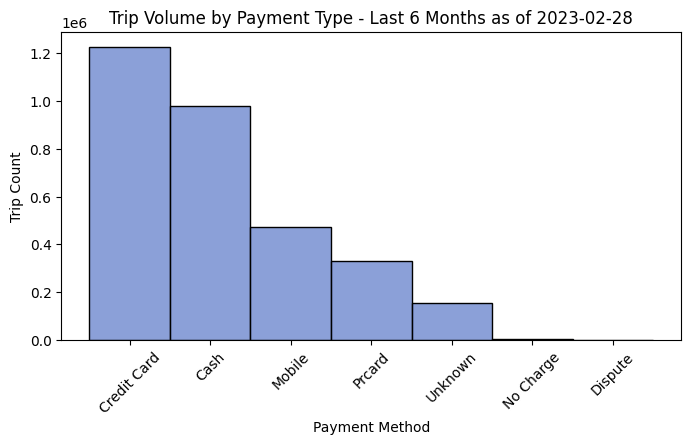

In [154]:
data_source6 = last_6_months_df.groupby(by=['PAYMENT_TYPE'], as_index=False).agg({'TRIP_COUNT': 'sum'}).sort_values('TRIP_COUNT', ascending=False)

# TO DO: change scale of y-axis labels

plt.figure(figsize=(8, 4))
sns.histplot(data=data_source6, x='PAYMENT_TYPE', weights='TRIP_COUNT', discrete=True , color='#6480CC')
plt.xlabel('Payment Method')
plt.ylabel('Trip Count')
plt.title(f"Trip Volume by Payment Type - Last 6 Months as of {today}")

plt.xticks(rotation=45)

plt.show()

# Taxi Fleet Utilization Rates



In [54]:
data_source5 = last_90_days_df_det.groupby(by=['COMPANY', 'TAXI_ID', 'DATE'], as_index=False).agg({'TRIP_COUNT': 'sum', 'TOTAL_REVENUE_EXC_TIP': 'sum', 'TRIP_DURATION_MINS': 'sum'}).sort_values(['DATE', 'COMPANY', 'TRIP_COUNT'], ascending=[True, True, False])

# Calculate Utilization Rate - this is defined as the % of time within the 24 hour day that a taxi is spend on trips
data_source5['UTILIZATION_RATE'] = ((data_source5['TRIP_DURATION_MINS'] / (24 * 60) )*100 ).round(1)



### Boxplot showing range of taxi utilization rates for top 10 companies by total trip volume

In [74]:
# For boxplot, aggregate to company and taxi_id only
company_taxis_utilization_rates = data_source5.groupby(by=['COMPANY', 'TAXI_ID'], as_index=False).agg({'UTILIZATION_RATE': 'mean', 'TRIP_COUNT': 'sum'})
company_taxis_utilization_rates['UTILIZATION_RATE'] = company_taxis_utilization_rates['UTILIZATION_RATE'].round(1)

In [103]:
# In order to get Top 10 companies by trip count - first get trip_count_sum partitioned over company, then dense rank
company_taxis_utilization_rates['trip_count_sum'] = company_taxis_utilization_rates.groupby('COMPANY')['TRIP_COUNT'].transform('sum')

# Add a new column 'dense_rank' representing the dense rank when sorting by 'trip_count_sum'
company_taxis_utilization_rates['dense_rank'] = company_taxis_utilization_rates['trip_count_sum'].rank(method='dense', ascending=False)
company_taxis_utilization_rates = company_taxis_utilization_rates.sort_values('dense_rank')

# Finally, filter to only keep top 10 companies by trip count and only columns needed
filtered_utilization_rates = company_taxis_utilization_rates[company_taxis_utilization_rates['dense_rank'] <= 10]
filtered_utilization_rates = filtered_utilization_rates[['COMPANY', 'TAXI_ID', 'UTILIZATION_RATE']]

# Display the modified DataFrame
#print(company_taxis_utilization_rates.head())

In [104]:
filtered_utilization_rates

,COMPANY,TAXI_ID,UTILIZATION_RATE
1645,Flash Cab,ecead90fbce17cf5db4e9c322c3e9728a63c780a40c0fd...,7.0
1561,Flash Cab,c25a629b09eb8c712ecc8a857390217f3bb7805736dc2a...,11.2
1680,Flash Cab,f77137daa0f4e8b987713cdc1fa289b0500e50117421fb...,15.8
1694,Flash Cab,ff60dabe17243a25435dcaf430a8b31615374bfc6be841...,10.5
1693,Flash Cab,ff17670d96389440510dbf6c0dbfa442be6431b76d0d4c...,8.5
...,...,...,...
432,Blue Ribbon Taxi Association,5bfb9541130de6ef19718fe402d5734e08bfd567afa2ae...,9.0
431,Blue Ribbon Taxi Association,5aa1b2790d2fa6c1d5331cc3c58058cba4a8172ec2a70f...,1.6
429,Blue Ribbon Taxi Association,55893ca2684fdf43ca8b1dbc73ba723432268baf2e1fe2...,18.5
428,Blue Ribbon Taxi Association,5386b76b5418d11895d0e7303b3be997cb010161807004...,8.1


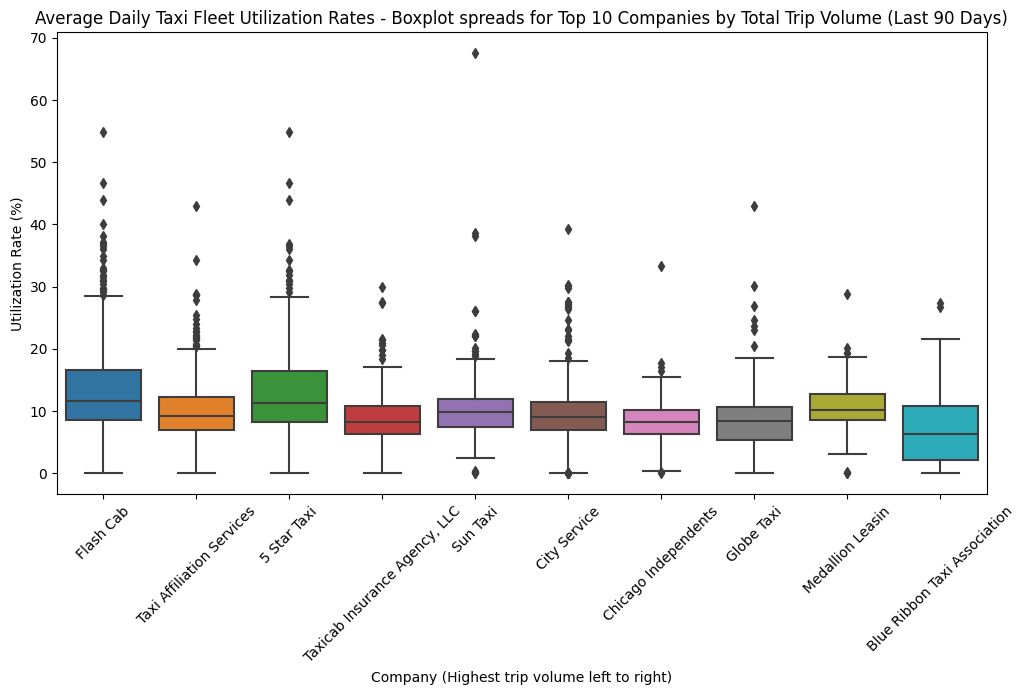

In [111]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='COMPANY', y='UTILIZATION_RATE', data=filtered_utilization_rates)

plt.title('Average Daily Taxi Fleet Utilization Rates - Boxplot spreads for Top 10 Companies by Total Trip Volume (Last 90 Days)')
plt.xlabel('Company (Highest trip volume left to right)')
plt.ylabel('Utilization Rate (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [59]:
# Overall average utilization rate by day since 1st Jan 2022 

date_utilization_rates = data_source5.groupby(by=['DATE'], as_index=False).agg({'UTILIZATION_RATE': 'mean'})
date_utilization_rates['UTILIZATION_RATE'] = date_utilization_rates['UTILIZATION_RATE'].round(1)

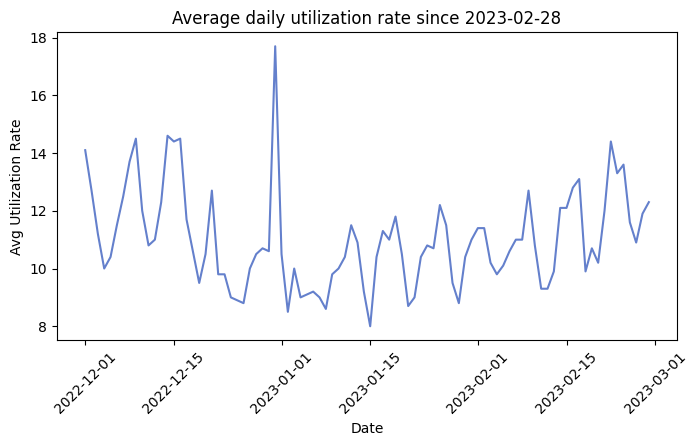

In [65]:
plt.figure(figsize=(8, 4))
sns.lineplot(x='DATE', y='UTILIZATION_RATE', data=date_utilization_rates, color='#6480CC')
plt.title(f"Average daily utilization rate since {today}")
plt.xlabel('Date')
plt.ylabel('Avg Utilization Rate')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

# Short Trips vs Long Trips - INCOMPLETE

In [117]:
data_source = last_6_months_df_det.groupby(by=['DAY', 'IS_SHORT_TRIP'], as_index=False).agg({'TRIP_COUNT': 'sum'}).sort_values('DAY')

In [118]:
data_source

,DAY,IS_SHORT_TRIP,TRIP_COUNT
0,Friday,0,34537.0
1,Friday,1,52794.0
2,Monday,0,36798.0
3,Monday,1,45111.0
4,Saturday,0,26978.0
5,Saturday,1,41881.0
6,Sunday,0,29531.0
7,Sunday,1,31437.0
8,Thursday,0,35351.0
9,Thursday,1,52931.0


# Tipping Behaviour - INCOMPLETE

Context:

Tipping behaviour means how often and how much passengers tip. Although many factors could influence tipping behaviour, the overall product and service design may affect tipping behaviour. Tipping is likely benefical to driver retention and satisfacton, which are important to the success of BluesMobile Taxis, so we want to make some informed hypotheses around some of the factors that increase tipping.

Source table:

- average tips rate and %
- tip rate by payment method and company (heat map)
- avg tip % by company
- tipping by trip distance/duration
- variance by taxi (vehicle and/pr driver may have an impact)

Further analysis:

We would expect tipping behaviour also to be strongly correlated with:
The taxi driver. This data is not available but we can use taxi_id to estimate. However we don't know to what extent taxis are shared between drivers.
Demographics -> The pickup and dropoff locations could be a good proxy for this
Time of day -> May correlate to different use cases or trip purposes where tipping is more or less likely

In [37]:
data_source = last_6_months_df_det.groupby(by=['COMPANY', 'PAYMENT_TYPE', 'HAS_TIP'], as_index=False).agg({'TRIP_COUNT': 'sum'})
data_source['TRIPS_WITH_TIP'] = data_source['TRIP_COUNT'] * data_source['HAS_TIP']
data_source2 = data_source.groupby(by=['COMPANY', 'PAYMENT_TYPE'], as_index=False).agg({'TRIPS_WITH_TIP': 'sum', 'TRIP_COUNT': 'sum'})

In [43]:
data_source2['TIP_RATE'] = ((data_source2['TRIPS_WITH_TIP'] / data_source2['TRIP_COUNT'])*100).round(1)

In [48]:
data_source2.head(1)

,COMPANY,PAYMENT_TYPE,TRIPS_WITH_TIP,TRIP_COUNT,TIP_RATE
0,24 Seven Taxi,Cash,0.0,2347.0,0.0


In [ ]:
pivoted_data = data_source2.pivot_table(index='COMPANY', columns='PAYMENT_TYPE', values='TIP_RATE')

# HEATMAP

sns.heatmap(pivoted_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Tip Rate (%)'})

# Set axis labels
plt.xlabel('Payment Type')
plt.ylabel('Company')

plt.show()

# More ideas - INCOMPLETE

### Trip Duration

Context:

Source table:

- percent of short trips

- By day of week
- Week days vs weekend
- By payment method

Potential issues:

Further analysis:

### Fleet Metrics

Context:


Source table:

- Fleet size by company
- Total revenue per taxi by company
- Fleet utilization rates

Potential issues:

Further analysis:

How does pickup location (pickup community area) vary by day and time?
How crowded is the market? Top companies by share of market
Do particular companies dominate certain areas?

Tipping behaviour
How does tipping behaviour vary by payment type? (is there some flow in the CX that encourages/discourages tipping)
How does tipping behaviour vary by company (perhaps they are doing something differently) - % with tip, avg tip amount

Assuming long trips are good:
How does trip duration vary by pickup time, pickup location/area
Does trip duration vary by company? (might indicate that different companies won't take short trips)

Pricing:
what is the average fare price by company

Taxis:
Fleet size -> how many unqiue taxi IDs per company
Utilisation rate -> For each unique taxi ID, what % of the day is a trip (using total trip duration), copmare across companies & days